In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import inv
import time as time
from IPython.display import display, Audio
from scipy.sparse import dia_matrix, diags

%matplotlib widget

def ravel_index_from_true_indexes(x_idx, y_idx, Nx) :
    return y_idx*Nx + x_idx

def find_nearest_index(array, value, nearest_value=False):
    """
    # Inputs
    Takes an array and a value as arguments.

    # Ouputs
    Return the index of the nearest value. Also returns (nearest_idx, nearest_value) if nearest_value is True.
    """
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    if nearest_value :
        return idx, array[idx]
    return idx


In [2]:
def plaque_article():
    """
    rends dans l'ordre : 
    - MB : matrice des masses modales de la plaque
    - MB_inv : matrice inverse des masses modales de la plaque
    - CB : matrice des C modales de la plaque
    - KB : matrice des K modales de la plaque
    - phiB_NxNy_NmB : modes de la plaques
    - NmB : nombre de mode
    """
    xinB = np.array([2.2,1.1,1.6,1.0,0.7,0.9,1.1,0.7,1.4,0.9,0.7,0.7,0.6,1.4,1.0,1.3])/100
    fnB = np.array([78.3,100.2,187.3, 207.8, 250.9,291.8,314.7,344.5,399.0,429.6,482.9,504.2,553.9,580.3,645.7,723.5])
    MmB = np.array([2.91,0.45,0.09,0.25,2.65,9.88,8.75,8.80,0.90,0.41,0.38,1.07,2.33,1.36,2.02,0.45])
    NmB = len(fnB)

    wnB = 2 * np.pi * fnB
    phiB_NxNy_NmB = np.ones(NmB)
    MB = np.diag(MmB)
    MB_inv = np.diag(1/MmB)
    CB = np.diag(2*MmB*wnB*xinB)
    KB = np.diag(MmB*wnB**2)
    return(MB,MB_inv,CB,KB,phiB_NxNy_NmB,NmB)

def plaque_model(h = 2.8e-3,nu = 0.2,E = 7e9,rho = 400,Lx = 40e-2,Ly = 40e-2):
    """
    rends dans l'ordre : 
    - MB : matrice des masses modales de la plaque
    - MB_inv : matrice inverse des masses modales de la plaque
    - CB : matrice des C modales de la plaque
    - KB : matrice des K modales de la plaque
    - phiB_NxNy_NmB : modes de la plaques
    - NmB : nombre de mode
    - x : discrétisation de la plaque en x
    - y : discrétisation de la plaque en y
    """
    ## Paramètres physique
    #h = 2.8e-3 #Epaisseur de  la plaque (m)
    #nu = 0.2 #Coeff de poisson (Pa)
    #E = 7e9 #Module de Young (Pa)
    #rho = 400 #Masse volumique (kg/m3)
    ##D = E*h**3/(12*(1-nu**2)) #Raideur de la plaque  : t'en as pas besoin???
    ##eta = 0.02 #Amortissement interne à la plaque à réfléchir 
    #Lx, Ly, Lz = 40e-2, 23.9e-2, h #Dimensions (m)
    #Lz = h t'en as pas besoin??

    ## Paramètres de discrétisation
    NB = 4          #Nombre de modes selon x
    MB = 4          #Nombre de modes selon y
    NmB = NB * MB      #Nombre de modes total considérés dans le modèle de plaque

    dx = 10e-3 #(10mm)
    dy = 10e-3 #(10mm)
    x = np.arange(0,Lx,dx)
    y = np.arange(0,Ly,dy)
    Nx = len(x)
    Ny = len(y)

    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes
    def omega_pq (p,q) :    #Calcul analytique des pulsations propres d'une plaque en appuis simple
        return np.sqrt(E*h**2/(12*rho*(1-nu**2))) * ((p*np.pi/Lx)**2+(q*np.pi/Ly)**2)

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant
    fnB = wnB/(2*np.pi)
    print(f"Fréquence du dernier mode de plaque calculé : {fnB[-1]:.0f} Hz")
    #xinB = np.array([eta/2]*NmB) 
    xinB = np.array([2.2,1.1,1.6,1.0,0.7,0.9,1.1,0.7,1.4,0.9,0.7,0.7,0.6,1.4,1.0,1.3])/100

    NmB_idx = NmB_idx[:,tri_idx]      #On ordonne les modes par ordre croissant

    ### Déformées
    def phi_pq (p,q,x,y) :  #Calcul analytique des déformées des modes d'une plaque en appuis simple
        return np.sin(p*np.pi*x/Lx)*np.sin(q*np.pi*y/Ly)

    phiB_NxNy_NmB = np.zeros((Nx*Ny,NmB)) #Matrice des déformées avec les 2 dimensions spatiales applaties en 1 dimension
    for mode in range (NmB) :
        for point in range(Nx*Ny) :
            n = NmB_idx[0,mode]
            m = NmB_idx[1,mode]
            x_ = X_ravel[point]
            y_ = Y_ravel[point]

            phiB_NxNy_NmB[point,mode] = phi_pq(n, m , x_, y_)

    ### Masses modales
    MmB = np.zeros(NmB)
    for j in range(NmB) :
        PHI_j_Ny_Nx = np.reshape(phiB_NxNy_NmB[:,j],(Ny,Nx))      #Correspond à la déformée du mode j sur la plaque (en 2D)
        MmB[j] = rho*h* np.sum(np.sum(PHI_j_Ny_Nx**2,axis=1),axis=0)*dx*dy

    #MmB /= 100

    ### Normalisation des masses modales
    norme_deformee_NmB = np.sqrt(MmB)         #Ref : Modal Testing Theory, Practice and Application p.54, Eq. (2.25)
    phiB_NxNy_NmB = phiB_NxNy_NmB[:,:] / norme_deformee_NmB[np.newaxis,:]

    MB = np.eye(NmB)
    MB_inv = MB
    CB = np.diag(2*MmB*wnB*xinB)
    KB = np.diag(MmB*wnB**2)

    return(MB,MB_inv,CB,KB,phiB_NxNy_NmB,NmB,x,y)

def créer_matrice(MS,MB,MS_inv,MB_inv,KS,KB,CS,CB):
    NmB = MB.shape[0]
    NmS = MS.shape[0]
    M = dia_matrix(np.block([
                 [MS               , np.zeros((NmS,NmB))],
                [ np.zeros((NmB,NmS)), MB               ]
                ]))
    M_inv = dia_matrix(np.block([
                 [MS_inv           , np.zeros((NmS,NmB))],
                 [np.zeros((NmB,NmS)), MB_inv              ]
                ]))

    K = dia_matrix(np.block([
                [KS               , np.zeros((NmS,NmB))],
                [np.zeros((NmB,NmS)), KB               ]
                ]))

    C = dia_matrix(np.block([
                [CS               , np.zeros((NmS,NmB))],
                [np.zeros((NmB,NmS)), CB               ]
                ]))
    return(M,M_inv,K,C)


In [25]:
def Bigidibig_matrice_totale(h = 2.8e-3, nu = 0.2, E_t = 7e9, rho = 400, Lx = 40e-2, Ly = 40e-2, T = 73.9, rho_l = 3.61 * 10**(-3), L = 0.65, E_c = 4, I = 10**(-5), Fe = 44100):
    ## Paramètres physique
    #h = 2.8e-3 #Epaisseur de  la plaque (m)
    #nu = 0.2 #Coeff de poisson (Pa)
    #E = 7e9 #Module de Young (Pa)
    #rho = 400 #Masse volumique (kg/m3)
    ##D = E*h**3/(12*(1-nu**2)) #Raideur de la plaque  : t'en as pas besoin???
    ##eta = 0.02 #Amortissement interne à la plaque à réfléchir 
    #Lx, Ly, Lz = 40e-2, 23.9e-2, h #Dimensions (m)
    #Lz = h t'en as pas besoin??

    ## Paramètres de discrétisation
    NB = 4          #Nombre de modes selon x
    MB = 4          #Nombre de modes selon y
    NmB = NB * MB      #Nombre de modes total considérés dans le modèle de plaque

    dx = 10e-3 #(10mm)
    dy = 10e-3 #(10mm)
    x = np.arange(0,Lx,dx)
    y = np.arange(0,Ly,dy)
    Nx = len(x)
    Ny = len(y)

    X_plate, Y_plate = np.meshgrid(x, y)
    X_ravel, Y_ravel = np.ravel(X_plate), np.ravel(Y_plate)

    ## Calcul des modes
    def omega_pq (p,q) :    #Calcul analytique des pulsations propres d'une plaque en appuis simple
        return np.sqrt(E_t*h**2/(12*rho*(1-nu**2))) * ((p*np.pi/Lx)**2+(q*np.pi/Ly)**2)

    wnB = np.zeros(NmB)
    NmB_idx = np.zeros((2,NmB))   #Cette liste permet de remonter du mode contracté "i" au mode réel (n_i,m_i) en appelant NmB_idx[:,i]
    j = 0
    for n in range(1,NB+1) :
        for m in range(1,MB+1) :
            wnB[j] = omega_pq(n,m)
            NmB_idx[0,j] = n
            NmB_idx[1,j] = m
            j += 1

    ### Tri par ordre de fréquences croissantes
    tri_idx = np.argsort(wnB)

    wnB = wnB[tri_idx]    #On range les pulsations par ordre croissant
    fnB = wnB/(2*np.pi)
    print(f"Fréquence du dernier mode de plaque calculé : {fnB[-1]:.0f} Hz")
    #xinB = np.array([eta/2]*NmB) 
    xinB = np.array([2.2,1.1,1.6,1.0,0.7,0.9,1.1,0.7,1.4,0.9,0.7,0.7,0.6,1.4,1.0,1.3])/100

    NmB_idx = NmB_idx[:,tri_idx]      #On ordonne les modes par ordre croissant

    ### Déformées
    def phi_pq (p,q,x,y) :  #Calcul analytique des déformées des modes d'une plaque en appuis simple
        return np.sin(p*np.pi*x/Lx)*np.sin(q*np.pi*y/Ly)

    phiB_NxNy_NmB = np.zeros((Nx*Ny,NmB)) #Matrice des déformées avec les 2 dimensions spatiales applaties en 1 dimension
    for mode in range (NmB) :
        for point in range(Nx*Ny) :
            n = NmB_idx[0,mode]
            m = NmB_idx[1,mode]
            x_ = X_ravel[point]
            y_ = Y_ravel[point]

            phiB_NxNy_NmB[point,mode] = phi_pq(n, m , x_, y_)

    ### Masses modales
    MmB = np.zeros(NmB)
    for j in range(NmB) :
        PHI_j_Ny_Nx = np.reshape(phiB_NxNy_NmB[:,j],(Ny,Nx))      #Correspond à la déformée du mode j sur la plaque (en 2D)
        MmB[j] = rho*h* np.sum(np.sum(PHI_j_Ny_Nx**2,axis=1),axis=0)*dx*dy

    #MmB /= 100

    ### Normalisation des masses modales
    norme_deformee_NmB = np.sqrt(MmB)         #Ref : Modal Testing Theory, Practice and Application p.54, Eq. (2.25)
    phiB_NxNy_NmB = phiB_NxNy_NmB[:,:] / norme_deformee_NmB[np.newaxis,:]

    MB = np.ones(NmB)
    MB_inv = MB
    CB = 2 * MmB * wnB * xinB
    KB = MmB * wnB ** 2
    
    ################################## cordes
    ## Paramètres physique
    #L = 0.65 #longueur de corde (m) # à changer dans la def de simu_config si on change
    #f1 = 110 #freq de la corde (hz)
    #T = 73.9 #tension de la corde (N)
    #rho_l = 3.61 * 10**(-3) #masse linéique (kg/m)
    ct = np.sqrt(T/rho_l) #célérité des ondes transverse (M/s)
    B = E_c * I
    #B = 4*10**(-5) #coefficient d'inarmonicité : B = E*I (N*m**2)

    ## Paramètres de discrétisation
    NmS = 50 #Modes de cordes
    NnS = np.arange(1,NmS+1)

   # NxS = 1000 #Discrétisation spatiale
    dx =  (ct+1) / Fe 
    xS = np.arange(0,L, dx)
    #xS = np.linspace(0,L,NxS) #Vecteur de la corde

    ## Calcul des modes
    phiS_Nx_NmS = np.sin((2*NnS[np.newaxis,:]-1)*np.pi*xS[:,np.newaxis] / 2 / L) #Déformées d'une corde fixe aux extrémités
    pnS = (2 * NnS - 1) * np.pi / (2 * L)
    fnS = (ct / 2 / np.pi) * pnS * (1 + pnS**2 * B / (2 * T)) #Fréquences propres de la corde (hz)
    #print(f"Fréquence du dernier mode de corde calculé : {fnS[-1]:.0f} Hz")
    wnS = 2*np.pi*fnS

    etaf, etaA, etaB = 7e-5, 0.9, 2.5e-2
    xinS = 1/2 * ( T*(etaf + etaA / 2 / np.pi / fnS) + etaB * B*pnS**2 ) / (T + B*pnS**2) #Amortissements modaux de la corde (ø)

    MmS = rho_l * L / 2  #Masses modales de la corde (kg)

    ### Matrices modales
    MS = np.ones(NmS) * MmS
    CS = MS * 2*wnS*xinS
    KS = MS * wnS**2
    MS_inv = np.ones(NmS) * (1/MmS)
    ###############bigmatrix :

    M_lin = np.concatenate((MS,MB))
    C_lin = np.concatenate((CS,MS))
    K_lin = np.concatenate((KS,KB))
    M_inv_lin = np.concatenate((MS_inv,MB_inv))

    M = diags(M_lin)
    M_inv = diags(M_inv_lin)
    K = diags(K_lin)
    C = diags(C_lin)

    return(M,M_inv, C,K, phiS_Nx_NmS,phiB_NxNy_NmB,NmS,NmB,x,y,xS)

In [23]:
def UK_params(M,M_inv,NmS, NmB, phiS_Nx_NmS,phiB_NxNy_NmB,xS,article = True, model = False, mode = 'A1',x =0, y = 0):
    phiSB = phiS_Nx_NmS[-1,:] #déformée de la corde au point du chevalet
    phiSF = phiS_Nx_NmS[int(len(xS)/4),:] #déformée de la corde au point d'appuis du doigt du guitariste

    if model : 
        Nx = len(x)
        Ny = len(y)
        #Point de couplage (par rapport à la table)
        xc, yc = x[int(24.5/40*Nx)], y[Ny//2]
        xc_idx, yc_idx = find_nearest_index(x, xc), find_nearest_index(y, yc)
        xyc = ravel_index_from_true_indexes(xc_idx, yc_idx, Nx)
        #pour modèle de la plaque:
        phiBS = phiB_NxNy_NmB[xyc,:]

    if article : 
        phiBS = phiB_NxNy_NmB

    if mode == 'A1':
        Aa = np.block([
                        [phiSB.T, np.zeros(NmB)],
                        [phiSF.T, np.zeros(NmB)]
        ])
    if mode == 'A2':
        Aa = np.block([
                        [phiSB.T, -phiBS],
                        [phiSF.T, np.zeros(NmB)]
        ])


    M_inv_demi = M_inv.sqrt()
    print(Aa.shape)
    print(M_inv_demi.shape)
    B = Aa @ M_inv_demi
    Bplus = B.T @ np.linalg.inv((B @ B.T))
    W = np.eye(NmS+NmB) - M_inv_demi @ Bplus @ Aa

    Z = - M.sqrt() @ Bplus @ Aa #pour calculer la force ensuite

    return(W,Z)

In [96]:
def Simu_config(xS,Fe = 44100, T = 3):
    """
    entrée :
    xS : discrétisation de la corde
    Fe : fréquence d'échantillonnage
    T ; temps d'acquisition
    
    sortie : 
    t : vecteur de temps
    FextS_NxS_Nt : Force dans la matrice spatiale

    """
    # Vecteur temps
    #Fe = int(2.2*max(fnS[-1], fnB[-1])) #Fréquence d'échantillonnage (hz) (on prends un peu plus que la limite pour respecter Shannon pour optimiser)
    # Fe = 44100
    # print(f"Fréquence d'échantillonage : {Fe} Hz")
    #T = 10 #Temps d'acquisition (s)
    # print(f"Temps d'acquisition : {T} s")
    t = np.linspace(0, T, T*Fe) #Vecteur temps
    Nt = len(t)
    L = 0.65 #a changer dans la def de corde si on change

    # Force extérieure appliquée à la corde
    Fext = np.zeros_like(t)
    idx_deb = 0
    idx_fin = int(0.4*1e-3*Fe)
    Fext[idx_deb:idx_fin] = np.linspace(0,1,idx_fin - idx_deb) * 0.187 #Dans ce cas, Fext est une rampe

    xe_idx = find_nearest_index(xS, 0.9*L)
    NxS = len(xS)

    FextS_NxS_Nt = np.zeros((NxS,Nt))
    FextS_NxS_Nt[xe_idx, : ] = Fext

    plot_fext = True
    if plot_fext :
        fig = plt.figure()
        ax1 = fig.add_subplot(111)

        ax1.plot(t,Fext,label="")
        ax1.grid()
        #ax1.legend()
        ax1.set_xlabel("Temps (s)")
        ax1.set_ylabel("Force (N)")
        ax1.set_title(rf"Force extérieure appliquée au point $x_e$={xS[xe_idx]:.1f}")

        fig.tight_layout()

        plt.show()
    return(t,FextS_NxS_Nt)

In [97]:
def lounch_simu_article(t,FextS_NxS_Nt,phiS_Nx_NmS,NmS,NmB,M_inv,C,K,Z,W):
    F_pro_cor = phiS_Nx_NmS.T @ FextS_NxS_Nt # projection de la force
    point_temp = len(t)
    #print(NmS,NmB,point_temp,FextS_NxS_Nt.shape)
    #comme il n'y a pas de force extérieur sur la table, leur projection sur la base modale vaut 0
    F_pro_tot = np.zeros((NmS+NmB,point_temp)) 
    F_pro_tot[:NmS,:] = F_pro_cor

    #initialisation du shéma numérique de résolution
    q_temp = np.zeros((NmS + NmB, point_temp))
    q_dd_temp = np.zeros((NmS + NmB, point_temp))
    q_d_temp = np.zeros(NmS + NmB)
    q_d_temp_demi = np.zeros_like(q_d_temp)
    q_pour_f = np.zeros_like(q_temp)

    #shéma
    h = t[1] - t[0] #step d'intégration

    for i in range(point_temp - 1):
        q_temp[:,i+1] = q_temp[:,i] + h * q_d_temp + 0.5 * h**2 * q_dd_temp[:,i]
        q_d_temp_demi = q_d_temp + 0.5 * h * q_dd_temp[:,i]

        F_temp = - C.dot(q_d_temp_demi) - K.dot(q_temp[:,i+1]) + F_pro_tot[:,i+1]
        q_pour_f[:,i+1] = M_inv.dot(F_temp)

        q_dd_temp[:,i+1] = W @  q_pour_f[:,i+1]

        q_d_temp = q_d_temp + 0.5 * h * (q_dd_temp[:,i] + q_dd_temp[:,i+1])

    Q = q_temp

    F_c = Z @ q_pour_f

    return(Q,F_c)

In [98]:
def corde(T = 73.9, rho_l = 3.61 * 10**(-3), L = 0.65, E = 4, I = 10**(-5), Fe = 44100):

    """
    Rends dans l'ordre : 
    - MS : matrice des masses modales de la corde
    - MS_inv : matrice des masses modales inverses de la corde
    - CS : matrice des C modales de la corde
    - KS : matrice des K modaux de la corde
    - phiS_Nx_NmS : déformés de la corde
    - NmS : nombre de mode de la corde
    - xS : vecteur spatial discret de la corde
    """

    ## Paramètres physique
    #L = 0.65 #longueur de corde (m) # à changer dans la def de simu_config si on change
    #f1 = 110 #freq de la corde (hz)
    #T = 73.9 #tension de la corde (N)
    #rho_l = 3.61 * 10**(-3) #masse linéique (kg/m)
    ct = np.sqrt(T/rho_l) #célérité des ondes transverse (M/s)
    B = E * I
    #B = 4*10**(-5) #coefficient d'inarmonicité : B = E*I (N*m**2)

    ## Paramètres de discrétisation
    NmS = 60 #Modes de cordes
    NnS = np.arange(1,NmS+1)

   # NxS = 1000 #Discrétisation spatiale
    dx =  (ct+1) / Fe 
    xS = np.arange(0,L, dx)
    #xS = np.linspace(0,L,NxS) #Vecteur de la corde

    ## Calcul des modes
    phiS_Nx_NmS = np.sin((2*NnS[np.newaxis,:]-1)*np.pi*xS[:,np.newaxis]/2/L) #Déformées d'une corde fixe aux extrémités
    pnS = (2 * NnS - 1) * np.pi / (2 * L)
    fnS = (ct / 2 / np.pi) * pnS * (1 + pnS**2 * B / (2 * T)) #Fréquences propres de la corde (hz)
    #print(f"Fréquence du dernier mode de corde calculé : {fnS[-1]:.0f} Hz")
    wnS = 2*np.pi*fnS

    etaf, etaA, etaB = 7e-5, 0.9, 2.5e-2
    xinS = 1/2 * ( T*(etaf + etaA / 2 / np.pi / fnS) + etaB * B*pnS**2 ) / (T + B*pnS**2) #Amortissements modaux de la corde (ø)

    MmS = rho_l * L / 2  #Masses modales de la corde (kg)

    ### Matrices modales
    MS = np.eye(NmS) * MmS
    CS = MS * np.diag(2*wnS*xinS)
    KS = MS*np.diag(wnS**2)
    MS_inv = np.eye(NmS) * (1/MmS)

    return(MS,MS_inv, CS,KS, phiS_Nx_NmS,NmS,xS)

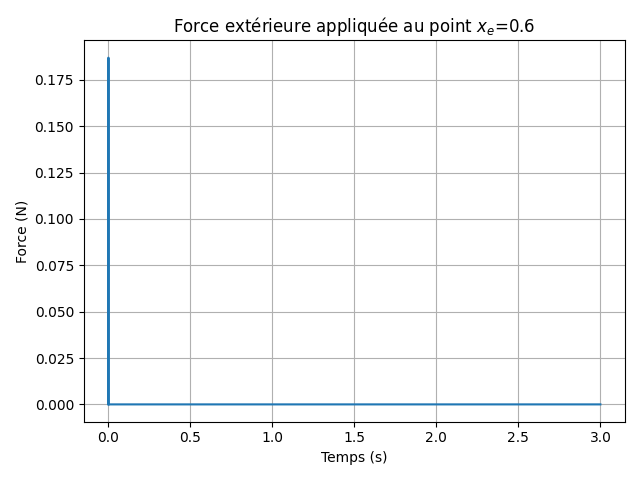

In [99]:
fe = 22000
MS, MS_inv, CS, KS, phiS_Nx_NmS, NmS, xS = corde(Fe = fe)
t, FextS_NxS_Nt = Simu_config(xS,Fe = fe, T = 3)

In [100]:
MB_mod,MB_mod_inv, CB_mod,KB_mod,phiB_NxNy_NmB_mod,NmB_mod,x,y= plaque_model()

Fréquence du dernier mode de plaque calculé : 1084 Hz


In [101]:
M_mod, M_mod_inv, K_mod,C_mod = créer_matrice(MS,MB_mod,MS_inv,MB_mod_inv,KS,KB_mod,CS,CB_mod)

In [102]:
W_mod_a2,Z_mod_a2 = UK_params(M_mod,M_mod_inv,NmS, NmB_mod, phiS_Nx_NmS, phiB_NxNy_NmB_mod,xS, article = False, model = True, mode = 'A2',x = x, y = y)

(2, 76)
(76, 76)


In [103]:
Q_mod_a2,F_C_mod_a2 = lounch_simu_article(t,FextS_NxS_Nt,phiS_Nx_NmS,NmS,NmB_mod,M_mod_inv,C_mod,K_mod,Z_mod_a2,W_mod_a2)

In [104]:
def écouter_son(F,phiS_Nx_NmS,phiB_NxNy_NmB,NmS,Fe=44100):
    FS = F[:NmS,:]
    #FB = F[NmS:,:]
    FS_NxS_Nt = phiS_Nx_NmS @ FS
    #FB_NxNy_Nt = phiB_NxNy_NmB @ FB
    display(Audio(FS_NxS_Nt[-1,:], rate=Fe))

In [105]:
écouter_son(F_C_mod_a2,phiS_Nx_NmS,phiB_NxNy_NmB_mod,NmS)

In [27]:
fe = 30000
M, M_inv, C,K, phiS_Nx_NmS,phiB_NxNy_NmB,NmS,NmB,x,y,xS = Bigidibig_matrice_totale()
t, FextS_NxS_Nt = Simu_config(xS,Fe = fe, T = 3)

Fréquence du dernier mode de plaque calculé : 1084 Hz


(66, 66)

In [30]:
W_mod_a2,Z_mod_a2 = UK_params(M,M_inv,NmS, NmB_mod, phiS_Nx_NmS, phiB_NxNy_NmB_mod,xS, article = False, model = True, mode = 'A2',x = x, y = y)

(2, 66)
(66, 66)


In [31]:
Q_mod_a2,F_C_mod_a2 = lounch_simu_article(t,FextS_NxS_Nt,phiS_Nx_NmS,NmS,NmB_mod,M_mod_inv,C_mod,K_mod,Z_mod_a2,W_mod_a2)

ValueError: dimension mismatch